In [1]:
from __future__ import print_function
import h5py as h5
import numpy as np
#import numba
import sklearn
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

print ("Numpy      ver. ", np.__version__)
#print ("Numba      ver. ", numba.__version__)  ##  optimize numpy?!?
print ("H5Py       ver. ", h5.__version__)
print ("SKLearn    ver. ", sklearn.__version__)
print ("TensorFlow ver. ", tf.__version__)


import matplotlib
#matplotlib.use('agg')             ## Need for CMD
import matplotlib.pyplot as plt
%matplotlib inline


Numpy      ver.  1.17.4
H5Py       ver.  2.9.0
SKLearn    ver.  0.21.3
TensorFlow ver.  1.15.0


In [2]:
H5_FILE="white_h_4096_dm2.h5"
RATE=4096
H5_FILE="../white_h_8192_dm2.h5"
RATE=8192

#!wget http://grqc.ncts.ncku.edu.tw/~lincy/GWDA/white_h_8192_dm2.h5
#!ls /tmp/tf_tmp -al

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


# of whiten waveform for each set:  685


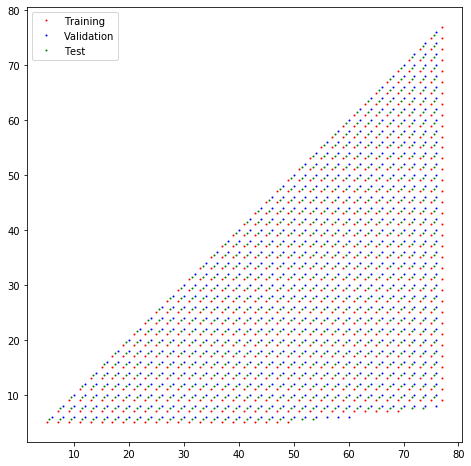

In [3]:
#### Now, visualize the dataset 
f = h5.File(H5_FILE,'r')
m1t = f['train_m1']
m2t = f['train_m2']
m1v = f['val_m1']
m2v = f['val_m2']
m1s = f['test_m1']
m2s = f['test_m2']

plt.figure(figsize=(8,8))
plt.plot(m2t, m1t, 'r.', markersize=2, label="Training")
plt.plot(m2v, m1v, 'b.', markersize=2, label="Validation")
plt.plot(m2s, m1s, 'g.', markersize=2, label="Test")
plt.axes().set_aspect('equal')
plt.legend()
#plt.show()
plt.savefig("template.png")

print ("# of whiten waveform for each set: ", len(f['train_hp']))

f.close()

In [4]:
###
###  Prepare data: extract, transform, load (ETL)
###
import time
#from datetime import datetime
from sklearn.model_selection import train_test_split

#FLAGS = tf.app.flags.FLAGS
#tf.app.flags.DEFINE_string("train_data_path", "/home/yongcai/chinese_fenci/train.txt", "training data dir")
#tf.app.flags.DEFINE_string("log_dir", "./logs", " the log dir")
#tf.app.flags.DEFINE_integer("max_sentence_len", 80, "max num of tokens per query")
#tf.app.flags.DEFINE_integer("shuffle_buffer_size", )

from sklearn.utils import shuffle

_NOISE_COPY_ = 1
class GWInject():
    def _shift_noise(self, tag, A, shift, nc):
        MAX=self.srate
        var = self.f[tag]
        NX = len(var)
        
        ## make shifted template first
        swf = np.zeros(var.shape)
        for i in range(NX):
            a = int((np.random.random()-0.5)*shift)  ## shift left or right
            swf[i,max(0,a):min(MAX, MAX+a)] += A * np.roll(var[i], a)[max(0,a):min(MAX, MAX+a)]
            
        NN = nc*NX
        noise = np.random.normal(0,1,(NN,self.srate))    
        X     = np.random.normal(0,1,(NX,self.srate)) + A * swf[:NX,:]
        if self.plot:
            plt.figure(figsize=(17,7))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)
                plt.ylim([-4,4])
                plt.plot(X[i,:], lw=1)
                plt.plot(A*swf[i,:], lw=1)
                plt.title("M:%g S:%g" % (X[i,:].mean(), X[i,:].std()) )
               
                if (i > 13): break
            plt.savefig("data.png")

        X = np.vstack( (noise, X )    ).astype(np.float32)
        Y = np.array([0]*NN + [1]*NX) .astype(np.float32).reshape(-1,1)
        #return shuffle(X, Y, random_state=0)
        return X, Y
    
    def _add_noise(self, tag, A, nc):
        var = self.f[tag]
        NX = len(var)
        NN = nc * NX
        noise = np.random.normal(0,1,(NN,self.srate))    
        X     = np.random.normal(0,1,(NX,self.srate))  + A * var[:NX,:]      
        if self.plot:
            plt.figure(figsize=(18,6))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)         
                plt.plot(X[i,:])
                plt.plot(A * var[i,:])
                #plt.title(" )
                if (i > 13): break
            plt.savefig("data.png")

        X = np.vstack( (noise, X )  ).astype(np.float32)
        Y = np.array([0]*NN + [1]*NX).astype(np.float32).reshape(-1,1)
        #return shuffle(X, Y, random_state=0)
        return X, Y
    
    def __init__(self, fname, plot=0):
        self.fname = fname
        self.plot = plot
        self.f = h5.File(fname, "r")
        self.srate = self.f.attrs.get('srate')   ##4096/ 8192
        print(self.srate, self.f.attrs.get('merger_idx'))
        
    def __exit__(self):
        self.f.close()
        
    def get_train_set(self, A=1.0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/train_hp', A, nc = nc)
        return X, Y
    def get_val_set(self, A=1.0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/val_hp', A, nc = nc)
        return X, Y
    def get_test_set(self, A=1.0):
        X, Y = self._add_noise('/test_hp', A, nc = _NOISE_COPY_)
        return X, Y

    def get_shifted_train_set(self, A=1.0, shift=0, nc = _NOISE_COPY_):
        X, Y = self._shift_noise('/train_hp', A, shift, nc = nc)
        #X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=None)
        return X, Y

    def get_shifted_test_set(self, A=1.0, shift=0, nc = _NOISE_COPY_):
        return self._shift_noise('/test_hp', A, shift, nc = nc)
    
    
tmp = GWInject(H5_FILE, plot=0)
X, Y = tmp.get_shifted_test_set(A=1, shift=0, nc = 2)  
#print(X.shape)
#print(X.shape)
#tmp.__exit__()


8192 0


In [5]:
###
### Prepare NN model: small model
###
def model(x_, keep_prob, WIDTH):
    feature = tf.reshape(x_, [-1, WIDTH,1])

    args = {"padding":'valid', "activation":tf.nn.relu,            #None,
            "kernel_initializer":tf.truncated_normal_initializer(), 
            #"bias_initializer":tf.truncated_normal_initializer()     }
            "bias_initializer":tf.zeros_initializer()     }
    
    def convl(in_, F, K, D, S, PO, PS, act):
        out = tf.layers.conv1d( in_, filters=F, kernel_size=K, dilation_rate=D, strides=S, **args)
        out = tf.layers.max_pooling1d(out, pool_size=PO, strides=PS, padding='valid')
        return out
        
    o1 = convl(feature, F=16, K=16, D=1, S=1, PO=4, PS=4, act=tf.nn.tanh)
    o2 = convl(o1,      F=32, K=8,  D=1, S=1, PO=4, PS=4, act=tf.nn.tanh)
    o3 = convl(o2,      F=64, K=8,  D=1, S=1, PO=4, PS=4, act=tf.nn.tanh)
    #o2 = convl(o1,      F=32, K=8,  D=4, S=1, PO=4, PS=4, act=tf.nn.relu)
    #o3 = convl(o2,      F=64, K=8,  D=4, S=1, PO=4, PS=4, act=tf.nn.relu)
    
    dim = o3.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    o4 = tf.reshape(o3, [-1, fcnn])
    # Densely connected layer
    o4     = tf.layers.dense(o4, 64, activation=tf.nn.tanh, name="fc")
    logits = tf.layers.dense(o4, 1, activation=None)
    
    return logits

###
### Prepare NN model: larger model
###
def model_hi(x_, keep_prob, WIDTH):
    """
    Model that return logits
    """
    act = tf.nn.tanh
    args = {"padding":'valid',  #None, 
        "kernel_initializer":tf.truncated_normal_initializer(), 
        "bias_initializer":tf.zeros_initializer()     }
    def convl(in_, F, K, D, S, PO, PS, act):
        out = tf.layers.conv1d( in_, filters=F, kernel_size=K, dilation_rate=D, strides=S, activation=act, **args)
        out = tf.layers.max_pooling1d(out, pool_size=PO, strides=PS, padding='valid')
        return out
        #return act(out)
    
    feature = tf.reshape(x_, [-1, WIDTH,1])
    c1 = convl(feature, F= 64, K=16, D=1, S=1, PO=4, PS=4, act=tf.nn.tanh)
    c2 = convl(c1,      F=128, K=16, D=2, S=1, PO=4, PS=4, act=tf.nn.tanh)
    c3 = convl(c2,      F=256, K=16, D=2, S=1, PO=4, PS=4, act=tf.nn.tanh)
    c4 = convl(c3,      F=512, K=32, D=2, S=1, PO=4, PS=4, act=tf.nn.tanh)

    dim = c4.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    l1 = tf.reshape(c4, [-1, fcnn])
    
    l2     = tf.layers.dense(l1, 128, activation=tf.nn.tanh)
    l3     = tf.layers.dense(l2,  64, activation=tf.nn.tanh)
    logits = tf.layers.dense(l3,   1, activation=None)
   
    return logits


In [6]:
###
###  Construct TF graph
###
tf.reset_default_graph()
DIM   = RATE
LRATE = 1e-5   ##-4
keep_prob = tf.placeholder(tf.float32)   ##  for dropout, not used.
lrate     = tf.placeholder(tf.float32)
#bs        = tf.placeholder(tf.int64)     ##  use dynamics batch_size to account for train/test stage both

x = tf.placeholder(tf.float32, [None,DIM])
y = tf.placeholder(tf.float32, [None,1])

#logits = model(x, keep_prob, DIM)
logits = model_hi(x, keep_prob, DIM)

# Compute predictions
#with tf.name_scope('eval'):
predict_prob = tf.sigmoid(logits, name="sigmoid_tensor")
predict_op   = tf.cast( tf.round(predict_prob), tf.int32 )
#with tf.name_scope('loss'):
## with reduction compared to tf.nn.softmax_cross_entropy_with_logits_v2 
loss_op = tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=y)
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(LRATE).minimize(loss_op)
    #optimizer = tf.train.AdadeltaOptimizer(LRATE, rho=0.90, epsilon=1e-08).minimize(loss_op)
    #optimizer = tf.train.GradientDescentOptimizer(LRATE).minimize(loss_op)

#correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
#correct_prediction = tf.cast(correct_prediction, tf.float32)
#accuracy = tf.reduce_mean(correct_prediction)
_, accuracy    = tf.metrics.accuracy(labels=y, predictions=predict_op  )
#_, sensitivity = tf.metrics.sensitivity_at_specificity(labels=y, predictions=predict_op, specificity=0.005 )
_, sensitivity = tf.metrics.recall(labels=y, predictions=predict_op)

#thres=[i*0.1+0.05 for i in range(10)]
#_, a2 = tf.metrics.sensitivity_at_specificity(labels=y, predictions=predict_prob,specificity=0.2)
#_, a4 = tf.metrics.sensitivity_at_specificity(labels=y, predictions=predict_prob,specificity=0.4)




_, fp = tf.metrics.false_positives(labels=y, predictions=predict_op  )
_, fn = tf.metrics.false_negatives(labels=y, predictions=predict_op  )
_, tp = tf.metrics.true_positives(labels=y, predictions=predict_op  )
_, tn = tf.metrics.true_negatives(labels=y, predictions=predict_op  )

#tf.summary.histogram('loss', loss_op)
#tf.summary.scalar('loss', loss_op)
#tf.summary.scalar('accuracy', accuracy)



Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling1D instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [7]:
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope("summaries_%s"% var.name.replace("/", "_").replace(":", "_")):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

    
### check all vari\ables
#tf.global_variables_initializer()
if 1:
    vars = 0
    for v in tf.global_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Whole size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.global_variables()) ) )

    vars = 0
    for v in tf.trainable_variables():
        print (v)
        variable_summaries(v)
        vars += np.prod(v.get_shape().as_list())
    print("Model size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.trainable_variables()) ) )

    vars = 0
    for v in tf.local_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Local var size: %.3f Bytes | Var # : %d" % (8*vars, len(tf.local_variables()) ) )

<tf.Variable 'conv1d/kernel:0' shape=(16, 1, 64) dtype=float32_ref>
<tf.Variable 'conv1d/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'conv1d_1/kernel:0' shape=(16, 64, 128) dtype=float32_ref>
<tf.Variable 'conv1d_1/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'conv1d_2/kernel:0' shape=(16, 128, 256) dtype=float32_ref>
<tf.Variable 'conv1d_2/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'conv1d_3/kernel:0' shape=(32, 256, 512) dtype=float32_ref>
<tf.Variable 'conv1d_3/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(7168, 128) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(128, 64) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'dense_2/kernel:0' shape=(64, 1) dtype=float32_ref>
<tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'optimizer/current_loss_scale:0' shape=() dtype=float32>
<tf.Variable 'o

In [8]:
BATCH = 256
EPOCHS = 5000
MONITOR = 10

PATIENCE = 4
TOLLERENCE = 1.e-8
##TOLLERENCE = 1.e-5

GWdata = GWInject(H5_FILE)  


8192 0


In [9]:
! ls /work/p00lcy01/

Cactus_src  VASP_tour  gamer	   lal	      lammps_koko     slurm_log  tfckpt
EXAMPLE     aaal       gpe	   lammps     lammps_koko_bm  src
LIN	    et	       gwda_model  lammps_bm  singularity     tb


In [25]:
##
##  Training with fixed template ....
##

#ROOT_FOLDER = './model'
ROOT_FOLDER = '/work/p00lcy01/gwda_model'

#TEST_LIST = [1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
TRAIN_A =   [2.0,1.6,1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5]
#TEST_LIST = [1.5, 1.4, 1.3, 1.2,1.1,1.0,0.9,0.8,0.7]
#TRAIN_A =   [1.4,1.2,1.0,0.8]

TRAIN_A =   [1.8, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8]


with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())   ### init w, bias to gaussian noise
    merged = tf.summary.merge_all()   ## call merged to do every summary
    saver = tf.train.Saver(max_to_keep=50)

    #load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, 1.0 ) )

    
    fig0 = plt.figure() ## plt loss 
    
    for amp in TRAIN_A:
        ## summarize to a new folder
        train_writer = tf.summary.FileWriter("%s/train_%4.2f" % (ROOT_FOLDER, amp ) )
        
        #train_writer.add_graph(tf.get_default_graph())
        #print('Saving graph to: %s' % ROOT_FOLDER)
    
        sess.run(tf.local_variables_initializer())  ###  only local vars like TP, TN, FP, FN to be init

        time0 = time.time()
        X0, Y0 = GWdata.get_train_set(A=amp, nc=2)
        X1, Y1 = GWdata.get_val_set(A=amp, nc=2)
        X = np.vstack( (X0,X1) ) 
        Y = np.vstack( (Y0,Y1) ) 
        
        print('=== get_train_setc ===   Reading time in sec :',  time.time()-time0 )

        print("Trainning for A= %f , dataset size: %d"% (amp, len(X) ))

        patience = 0
        time0 = time.time()
        
        loss_in_epoches = []
        for e in range(EPOCHS):
            Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=None)
            #Xt, _, Yt, _ = train_test_split(X, Y, test_size=0.01, shuffle=True, random_state=None)
            if (e%20==19):
                LRATE = LRATE*0.9
            
            STEPS   = int(len(Xt) / BATCH) 
            for i in range(STEPS):
                xbatch = Xt[i*BATCH:(i+1)*BATCH, :]
                ybatch = Yt[i*BATCH:(i+1)*BATCH, :]

                #_, loss = sess.run( [optimizer, loss_op], feed_dict={ x:xbatch, y:ybatch }   ) 
                #if (i%10==0): print('    Loss: %f', loss) 
                _ = sess.run( [optimizer], feed_dict={ x:xbatch, y:ybatch, lrate:LRATE }   ) 

                #_, summary = sess.run( [optimizer, merged], feed_dict={ x:xbatch, y:ybatch }   ) 
                #train_writer.add_summary(summary, global_step=e)

            ### evaluate    
            loss, acc, sen = sess.run( [loss_op, accuracy, sensitivity],   feed_dict={x:Xv, y:Yv} )
            loss_in_epoches.append(loss)

            if e % MONITOR == 0:
                duration = time.time() - time0
                speed = STEPS * BATCH * (e+1) / duration
                print('  Epoch: %3d, loss: %10.3e acc: %4.2g sen: %4.2f sec: %5.1f speed: %7.1f wf/sec' 
                      % (e, loss, acc, sen, duration, speed) )
            if loss < TOLLERENCE:
                if patience > PATIENCE: break
                patience += 1
            else:
                patience = 0
        
        
        save_path = saver.save(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, amp ) )
        print("Model saved at %s" % save_path)
        
        ### plot in each epoch
        plt.semilogy(loss_in_epoches, lw=1, label="A=%s"%amp)
        
    plt.legend()
    #fig0.show()
    fig0.savefig("loss.png")
    
        
        


=== get_train_setc ===   Reading time in sec : 1.282773494720459
Trainning for A= 1.800000 , dataset size: 4029
  Epoch:   0, loss:  6.009e-01 acc: 0.68 sen: 0.18 sec:   2.1 speed:  1353.1 wf/sec
  Epoch:  10, loss:  2.360e-01 acc: 0.85 sen: 0.59 sec:   6.8 speed:  4529.9 wf/sec
  Epoch:  20, loss:  1.116e-01 acc: 0.91 sen: 0.76 sec:  11.6 speed:  5109.6 wf/sec
  Epoch:  30, loss:  6.176e-02 acc: 0.94 sen: 0.84 sec:  16.3 speed:  5342.1 wf/sec
  Epoch:  40, loss:  3.712e-02 acc: 0.96 sen: 0.88 sec:  21.1 speed:  5479.8 wf/sec
  Epoch:  50, loss:  2.633e-02 acc: 0.96 sen: 0.90 sec:  25.8 speed:  5559.8 wf/sec
  Epoch:  60, loss:  1.949e-02 acc: 0.97 sen: 0.92 sec:  30.6 speed:  5618.1 wf/sec
  Epoch:  70, loss:  1.459e-02 acc: 0.97 sen: 0.93 sec:  35.3 speed:  5664.1 wf/sec
  Epoch:  80, loss:  1.163e-02 acc: 0.98 sen: 0.94 sec:  40.1 speed:  5692.3 wf/sec
  Epoch:  90, loss:  8.930e-03 acc: 0.98 sen: 0.94 sec:  44.8 speed:  5721.6 wf/sec
  Epoch: 100, loss:  8.077e-03 acc: 0.98 sen: 0.

  Epoch: 970, loss:  3.167e-05 acc:    1 sen: 0.99 sec: 462.6 speed:  5911.1 wf/sec
  Epoch: 980, loss:  3.146e-05 acc:    1 sen: 0.99 sec: 467.3 speed:  5912.0 wf/sec
  Epoch: 990, loss:  2.987e-05 acc:    1 sen: 0.99 sec: 471.9 speed:  5913.3 wf/sec
  Epoch: 1000, loss:  2.875e-05 acc:    1 sen: 0.99 sec: 476.6 speed:  5914.0 wf/sec
  Epoch: 1010, loss:  2.739e-05 acc:    1 sen: 0.99 sec: 481.3 speed:  5915.1 wf/sec
  Epoch: 1130, loss:  1.683e-05 acc:    1 sen: 1.00 sec: 538.3 speed:  5916.9 wf/sec
  Epoch: 1140, loss:  1.626e-05 acc:    1 sen: 1.00 sec: 543.0 speed:  5917.5 wf/sec
  Epoch: 1150, loss:  1.548e-05 acc:    1 sen: 1.00 sec: 547.7 speed:  5917.5 wf/sec
  Epoch: 1160, loss:  1.495e-05 acc:    1 sen: 1.00 sec: 552.6 speed:  5916.3 wf/sec
  Epoch: 1170, loss:  1.433e-05 acc:    1 sen: 1.00 sec: 557.4 speed:  5916.4 wf/sec
  Epoch: 1180, loss:  1.400e-05 acc:    1 sen: 1.00 sec: 562.1 speed:  5916.1 wf/sec
  Epoch: 1190, loss:  1.348e-05 acc:    1 sen: 1.00 sec: 567.0 speed

  Epoch: 2050, loss:  3.685e-07 acc:    1 sen: 1.00 sec: 976.2 speed:  5916.4 wf/sec
  Epoch: 2060, loss:  3.536e-07 acc:    1 sen: 1.00 sec: 981.0 speed:  5916.5 wf/sec
  Epoch: 2070, loss:  3.407e-07 acc:    1 sen: 1.00 sec: 985.7 speed:  5916.4 wf/sec
  Epoch: 2080, loss:  3.280e-07 acc:    1 sen: 1.00 sec: 990.4 speed:  5916.8 wf/sec
  Epoch: 2090, loss:  3.164e-07 acc:    1 sen: 1.00 sec: 995.2 speed:  5916.9 wf/sec
  Epoch: 2100, loss:  3.036e-07 acc:    1 sen: 1.00 sec: 999.8 speed:  5917.4 wf/sec
  Epoch: 2110, loss:  2.918e-07 acc:    1 sen: 1.00 sec: 1004.5 speed:  5917.7 wf/sec
  Epoch: 2120, loss:  2.802e-07 acc:    1 sen: 1.00 sec: 1009.3 speed:  5917.9 wf/sec
  Epoch: 2130, loss:  2.714e-07 acc:    1 sen: 1.00 sec: 1014.0 speed:  5918.2 wf/sec
  Epoch: 2140, loss:  2.602e-07 acc:    1 sen: 1.00 sec: 1018.7 speed:  5918.3 wf/sec
  Epoch: 2150, loss:  2.523e-07 acc:    1 sen: 1.00 sec: 1023.5 speed:  5918.3 wf/sec
  Epoch: 2160, loss:  2.393e-07 acc:    1 sen: 1.00 sec: 102

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

INFO:tensorflow:Restoring parameters from /work/p00lcy01/gwda_model/model_1.80.ckpt
Model restored from None
Test for A= 1.50 : Acc:     1.000, Sen:     1.000, TP/TN/FP/FN:   645   649     0     0 
Test for A= 1.40 : Acc:     1.000, Sen:     1.000, TP/TN/FP/FN:   647   647     0     0 
Test for A= 1.30 : Acc:     0.999, Sen:     0.998, TP/TN/FP/FN:   646   647     0     1 
Test for A= 1.20 : Acc:     0.978, Sen:     0.957, TP/TN/FP/FN:   616   650     0    28 
Test for A= 1.10 : Acc:     0.880, Sen:     0.759, TP/TN/FP/FN:   488   651     0   155 
Test for A= 1.00 : Acc:     0.668, Sen:     0.337, TP/TN/FP/FN:   218   647     0   429 
Test for A= 0.90 : Acc:     0.545, Sen:     0.087, TP/TN/FP/FN:    56   649     0   589 
Test for A= 0.80 : Acc:     0.508, Sen:     0.009, TP/TN/FP/FN:     6   651     0   637 
Test for A= 0.70 : Acc:     0.501, Sen:     0.002, TP/TN/FP/FN:     1   647     0   646 
Test for A= 0.60 : Acc:     0.501, Sen:     0.000, TP/TN/FP/FN:     0   648     0   646 
T

Test for A= 0.50 : Acc:     0.501, Sen:     0.002, TP/TN/FP/FN:     1   647     0   646 
Test for A= 0.40 : Acc:     0.499, Sen:     0.002, TP/TN/FP/FN:     1   645     1   647 
Test for A= 0.30 : Acc:     0.501, Sen:     0.000, TP/TN/FP/FN:     0   648     0   646 
Test for A= 0.20 : Acc:     0.499, Sen:     0.002, TP/TN/FP/FN:     1   645     1   647 
Test for A= 0.10 : Acc:     0.499, Sen:     0.000, TP/TN/FP/FN:     0   646     0   648 
INFO:tensorflow:Restoring parameters from /work/p00lcy01/gwda_model/model_1.10.ckpt
Model restored from None
Test for A= 1.50 : Acc:     0.999, Sen:     1.000, TP/TN/FP/FN:   648   645     1     0 
Test for A= 1.40 : Acc:     0.999, Sen:     1.000, TP/TN/FP/FN:   644   649     1     0 
Test for A= 1.30 : Acc:     0.999, Sen:     1.000, TP/TN/FP/FN:   646   647     1     0 
Test for A= 1.20 : Acc:     1.000, Sen:     1.000, TP/TN/FP/FN:   647   647     0     0 
Test for A= 1.10 : Acc:     1.000, Sen:     1.000, TP/TN/FP/FN:   646   648     0     0 
T

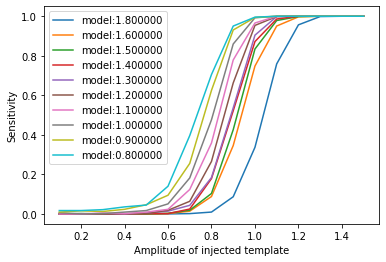

In [10]:
###
###  Testing...
###
BATCH = 4096
ROOT_FOLDER = '/work/p00lcy01/gwda_model'

#TEST_LIST = [1.4, 1.2, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
TRAIN_A =   [1.8, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8]
TEST_LIST = [1.5,1.4, 1.3, 1.2,1.1,1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

with tf.Session() as sess:
    
    test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test')
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=50)

    plt.figure()
    for m in TRAIN_A:
        #try:
        load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, m ) )
        print("Model restored from %s" % load_path )
        #except: 
        ##    continue

        gacc=[]
        gsen=[]

        
        for amp in TEST_LIST:
            sess.run(tf.local_variables_initializer())
            
            X, Y  = GWdata.get_shifted_test_set(A=amp)
            Xts, _, Yts, _ = train_test_split(X, Y, test_size=0.01, shuffle=True, random_state=None)
            i=int(np.random.random()* int(len(Xts)/BATCH) )
            xbatch = Xts[i*BATCH:(i+1)*BATCH, :]
            ybatch = Yts[i*BATCH:(i+1)*BATCH, :]
            #Xts, Yts   = GWdata.get_shifted_test_set(A=amp, shift=2000)  

            acc, sen, ttp, ttn, tfp, tfn = sess.run([accuracy, sensitivity, tp, tn, fp, fn ], 
                                                          feed_dict={ x: xbatch, y: ybatch })
            gsen.append(sen)
            gacc.append(acc)
            print("Test for A= %4.2f : Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " 
                  % (amp, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(TEST_LIST, gsen, label="model:%f"%m)
    
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Sensitivity")
    plt.legend()
    #plt.show()
    plt.savefig("infer.png")


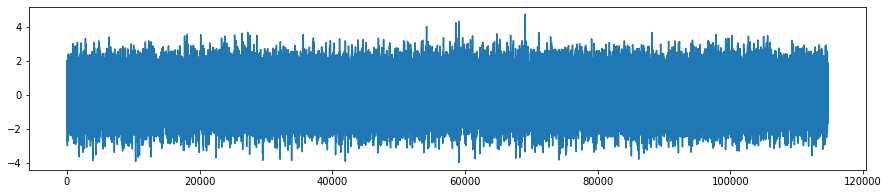

INFO:tensorflow:Restoring parameters from /work/p00lcy01/gwda_model/model_0.80.ckpt


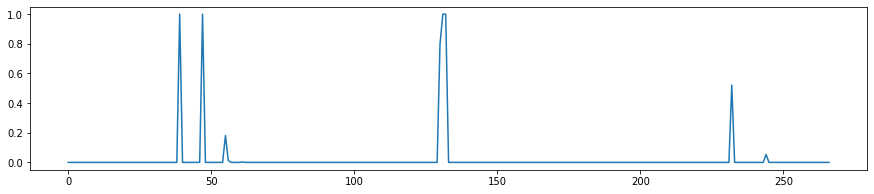

In [103]:
###
###  Testing real data...
###
wopt = {"figsize": (15,3) }

ROOT_FOLDER = '/work/p00lcy01/gwda_model'
TRAIN_A = [0.8]

SKIP = RATE  ##4*RATE   ## to remove the FFT gibbs effect
data = np.load("real8k/GW150914_H1_w.npy")[SKIP:-SKIP]
plt.figure(**wopt)
plt.plot(data)
plt.show()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=50)

    load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, TRAIN_A[-1] ) )
    sess.run(tf.local_variables_initializer())

    ## predict batch-by-batch    
    DS  = 400    ## every ~200 ms
    dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
    MB  = 256
    prob = np.zeros(dsn)
    for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

        batch  = min(i+MB, dsn) - i                 ### take care the tail
        xbatch = np.zeros([batch, RATE])
        for b in range(batch):
            s = int((b+i)*DS)
            xbatch[b,:] = data[s:s+RATE]
        [p_] = sess.run([predict_prob], feed_dict={ x: xbatch })
        prob[i: i + batch] = p_.flatten()
    
        
plt.figure(**wopt)
plt.plot(prob.flatten())




In [85]:
a[1:10]

array([0., 1., 1., 0., 0., 0., 0., 0., 0.])

8192 0


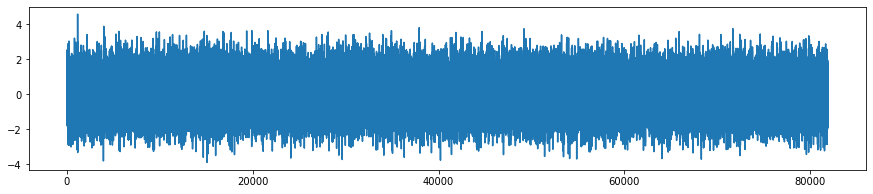

INFO:tensorflow:Restoring parameters from /work/p00lcy01/gwda_model/model_1.00.ckpt


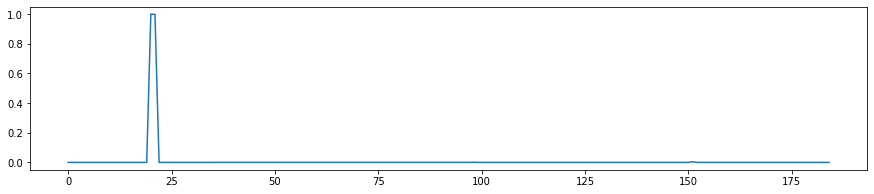

In [122]:
###
###  Testing fake data...
###
ROOT_FOLDER = '/work/p00lcy01/gwda_model'

TRAIN_A = [1.0]

def gen():
    
    tmp = GWInject(H5_FILE)
    inj = tmp.f['train_hp'][100]

    data = np.random.normal(0,1,RATE*10)
    data[RATE:2*RATE] += 0.8*inj 
    return data

data = gen()
plt.figure(**wopt)
plt.plot(data)
plt.show()


with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=50)

    load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, TRAIN_A[-1] ) )
    sess.run(tf.local_variables_initializer())

    ## predict batch-by-batch    
    DS  = 400    ## every ~200 ms
    dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
    MB  = 256
    prob = np.zeros(dsn)
    for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

        batch  = min(i+MB, dsn) - i                 ### take care the tail
        xbatch = np.zeros([batch, RATE])
        for b in range(batch):
            s = int((b+i)*DS)
            xbatch[b,:] = data[s:s+RATE]
        [p_] = sess.run([predict_prob], feed_dict={ x: xbatch })
        prob[i: i + batch] = p_.flatten()
    
        
plt.figure(**wopt)
plt.plot(prob.flatten())


